<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/Changing_QCNN_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 5.5MB/s 
     |████████████████████████████████| 18.0MB 121kB/s 
     |████████████████████████████████| 235kB 46.2MB/s 
     |████████████████████████████████| 215kB 52.5MB/s 
     |████████████████████████████████| 2.1MB 40.2MB/s 
     |████████████████████████████████| 1.5MB 41.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 194kB 47.5MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 614kB 39.2MB/s 
     |████████████████████████████████| 3.2MB 43.6MB/s 
     |████████████████████████████████| 6.3MB 36.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=1f10d4556d10b35a5aa2b81a80695b2698de59c20e7a8e9c4765a500bde2e1fb
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [2]:
# check if CUDA is available
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [9]:
len(cifar_trainset)

50000

In [11]:
from torch.utils.data import DataLoader, random_split

In [12]:
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

cifar_trainset, valid = random_split(cifar_trainset,[150,50])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)

In [19]:
@torch.no_grad()
def get_all_preds(model, test_loader):
    all_preds = torch.tensor([])
    for batch in test_loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

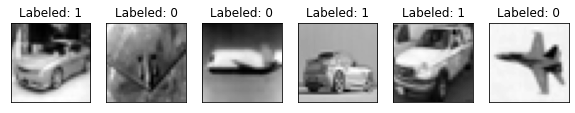

In [20]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
  
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [21]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

Files already downloaded and verified


Model one of the Hybrid Quantum Neural Network

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.481333 	Validation Loss: -0.763600
Epoch: 2 	Training Loss: -0.538333 	Validation Loss: -0.810200
Epoch: 3 	Training Loss: -0.635533 	Validation Loss: -0.823400
Epoch: 4 	Training Loss: -0.671000 	Validation Loss: -0.822000
Epoch: 5 	Training Loss: -0.701400 	Validation Loss: -0.856400
Epoch: 6 	Training Loss: -0.725867 	Validation Loss: -0.882600
Epoch: 7 	Training Loss: -0.733267 	Validation Loss: -0.919600
Epoch: 8 	Training Loss: -0.732933 	Validation Loss: -0.925400
Epoch: 9 	Training Loss: -0.759867 	Validation Loss: -0.926400
Epoch: 10 	Training Loss: -0.750933 	Validation Loss: -0.927800
Epoch: 11 	Training Loss: -0.765267 	Validation Loss: -0.952800
Epoch: 12 	Training Loss: -0.784600 	Validation Loss: -0.960400
Epoch: 13 	Training Loss: -0.783133 	Validation Loss: -0.970400
Epoch: 14 	Training Loss: -0.769800 	Validation Loss: -0.984000
Epoch: 15 	Training Loss: -0.803933 	Validation Loss: -0.987400
Epoch: 16 	Training Loss: -0.809933 	Validation L

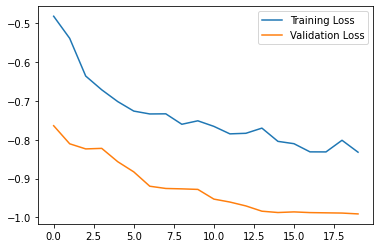

Performance on test data:
	Loss: -0.7624
	Accuracy: 81.5%


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.480067 	Validation Loss: -0.773400
Epoch: 2 	Training Loss: -0.482800 	Validation Loss: -0.809800
Epoch: 3 	Training Loss: -0.509600 	Validation Loss: -0.846200
Epoch: 4 	Training Loss: -0.521533 	Validation Loss: -0.858800
Epoch: 5 	Training Loss: -0.515667 	Validation Loss: -0.883800
Epoch: 6 	Training Loss: -0.512200 	Validation Loss: -0.887000
Epoch: 7 	Training Loss: -0.476533 	Validation Loss: -0.908200
Epoch: 8 	Training Loss: -0.513200 	Validation Loss: -0.919200
Epoch: 9 	Training Loss: -0.501467 	Validation Loss: -0.932400
Epoch: 10 	Training Loss: -0.518667 	Validation Loss: -0.928600
Epoch: 11 	Training Loss: -0.462267 	Validation Loss: -0.926800
Epoch: 12 	Training Loss: -0.530267 	Validation Loss: -0.928000
Epoch: 13 	Training Loss: -0.553400 	Validation Loss: -0.956600
Epoch: 14 	Training Loss: -0.638400 	Validation Loss: -0.969000
Epoch: 15 	Training Loss: -0.661067 	Validation Loss: -0.970400
Epoch: 16 	Training Loss: -0.680400 	Validation L

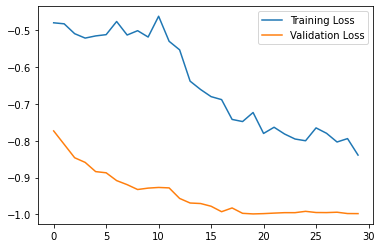

Performance on test data:
	Loss: -0.7898
	Accuracy: 83.0%


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Model 2 changing 500->20

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2) #Added layer
        x = F.relu(self.conv2(x))
        x = self.dropout(x) #Added layer
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

        

Epoch: 1 	Training Loss: -0.458667 	Validation Loss: -0.559800
Epoch: 2 	Training Loss: -0.504133 	Validation Loss: -0.597200
Epoch: 3 	Training Loss: -0.495733 	Validation Loss: -0.573600
Epoch: 4 	Training Loss: -0.451867 	Validation Loss: -0.592400
Epoch: 5 	Training Loss: -0.500600 	Validation Loss: -0.595400
Validation loss decreased (inf --> -0.920000).  Saving model ...


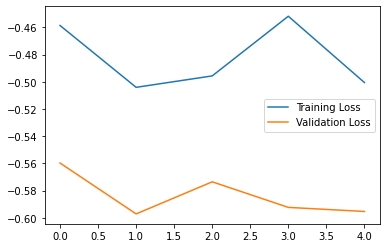

Performance on test data:
	Loss: -0.5111
	Accuracy: 53.5%


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.476067 	Validation Loss: -0.512200
Epoch: 2 	Training Loss: -0.479400 	Validation Loss: -0.556600
Epoch: 3 	Training Loss: -0.493467 	Validation Loss: -0.471000
Epoch: 4 	Training Loss: -0.497200 	Validation Loss: -0.578200
Epoch: 5 	Training Loss: -0.503533 	Validation Loss: -0.421400
Epoch: 6 	Training Loss: -0.492867 	Validation Loss: -0.566400
Epoch: 7 	Training Loss: -0.538533 	Validation Loss: -0.509000
Epoch: 8 	Training Loss: -0.539067 	Validation Loss: -0.485000
Epoch: 9 	Training Loss: -0.524600 	Validation Loss: -0.479400
Epoch: 10 	Training Loss: -0.516667 	Validation Loss: -0.651000
Epoch: 11 	Training Loss: -0.507600 	Validation Loss: -0.432000
Epoch: 12 	Training Loss: -0.486533 	Validation Loss: -0.483800
Epoch: 13 	Training Loss: -0.459133 	Validation Loss: -0.467400
Epoch: 14 	Training Loss: -0.527800 	Validation Loss: -0.524200
Epoch: 15 	Training Loss: -0.453067 	Validation Loss: -0.523400
Epoch: 16 	Training Loss: -0.500267 	Validation L

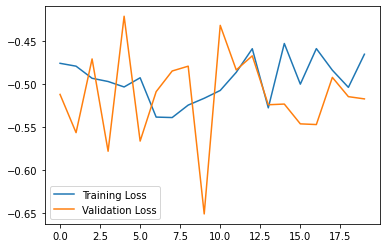

Performance on test data:
	Loss: -0.4965
	Accuracy: 49.0%


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Model 3

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)   #Added layer
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.502800 	Validation Loss: -0.486600
Epoch: 2 	Training Loss: -0.509467 	Validation Loss: -0.497600
Epoch: 3 	Training Loss: -0.509267 	Validation Loss: -0.507600
Epoch: 4 	Training Loss: -0.474733 	Validation Loss: -0.505400
Epoch: 5 	Training Loss: -0.506067 	Validation Loss: -0.524200


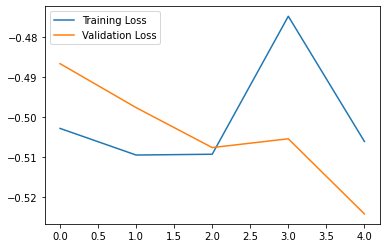

Performance on test data:
	Loss: -0.5487
	Accuracy: 50.0%


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))




#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.487933 	Validation Loss: -0.501400
Epoch: 2 	Training Loss: -0.469600 	Validation Loss: -0.526600
Epoch: 3 	Training Loss: -0.484800 	Validation Loss: -0.548600
Epoch: 4 	Training Loss: -0.500800 	Validation Loss: -0.561200
Epoch: 5 	Training Loss: -0.514000 	Validation Loss: -0.598800
Epoch: 6 	Training Loss: -0.497400 	Validation Loss: -0.690600
Epoch: 7 	Training Loss: -0.502267 	Validation Loss: -0.769600
Epoch: 8 	Training Loss: -0.497667 	Validation Loss: -0.794000
Epoch: 9 	Training Loss: -0.569000 	Validation Loss: -0.814400
Epoch: 10 	Training Loss: -0.510467 	Validation Loss: -0.828600
Epoch: 11 	Training Loss: -0.521800 	Validation Loss: -0.855600
Epoch: 12 	Training Loss: -0.534067 	Validation Loss: -0.891400
Epoch: 13 	Training Loss: -0.546467 	Validation Loss: -0.872800
Epoch: 14 	Training Loss: -0.488400 	Validation Loss: -0.888000
Epoch: 15 	Training Loss: -0.505067 	Validation Loss: -0.881800
Epoch: 16 	Training Loss: -0.545133 	Validation L

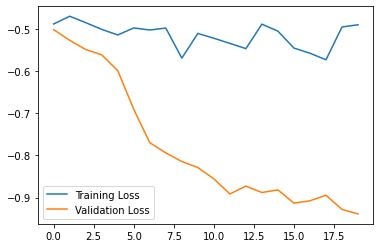

Performance on test data:
	Loss: -0.7300
	Accuracy: 75.5%


In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

model 4

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)   #Added layer
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Epoch: 1 	Training Loss: -0.490933 	Validation Loss: -0.486800
Epoch: 2 	Training Loss: -0.520467 	Validation Loss: -0.493600
Epoch: 3 	Training Loss: -0.510667 	Validation Loss: -0.499200
Epoch: 4 	Training Loss: -0.532467 	Validation Loss: -0.500200
Epoch: 5 	Training Loss: -0.521800 	Validation Loss: -0.502600
Validation loss decreased (inf --> -0.050000).  Saving model ...


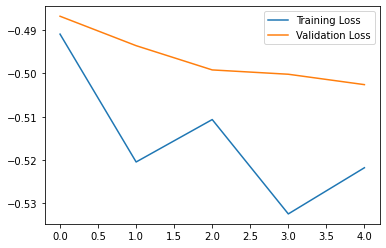

Performance on test data:
	Loss: -0.5097
	Accuracy: 50.0%


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Epoch: 1 	Training Loss: -0.495867 	Validation Loss: -0.524200
Epoch: 2 	Training Loss: -0.491200 	Validation Loss: -0.510400
Epoch: 3 	Training Loss: -0.512133 	Validation Loss: -0.534600
Epoch: 4 	Training Loss: -0.552400 	Validation Loss: -0.535400
Epoch: 5 	Training Loss: -0.492667 	Validation Loss: -0.574600
Epoch: 6 	Training Loss: -0.516000 	Validation Loss: -0.685000
Epoch: 7 	Training Loss: -0.489333 	Validation Loss: -0.668600
Epoch: 8 	Training Loss: -0.514267 	Validation Loss: -0.753200
Epoch: 9 	Training Loss: -0.469533 	Validation Loss: -0.778200
Epoch: 10 	Training Loss: -0.474800 	Validation Loss: -0.797600
Epoch: 11 	Training Loss: -0.473800 	Validation Loss: -0.795200
Epoch: 12 	Training Loss: -0.466600 	Validation Loss: -0.793200
Epoch: 13 	Training Loss: -0.532733 	Validation Loss: -0.801600
Epoch: 14 	Training Loss: -0.461600 	Validation Loss: -0.795800
Epoch: 15 	Training Loss: -0.505133 	Validation Loss: -0.810200
Epoch: 16 	Training Loss: -0.501267 	Validation L

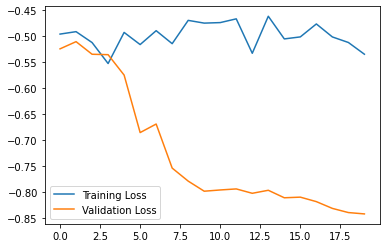

Performance on test data:
	Loss: -0.6903
	Accuracy: 73.0%


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
model = Net()
valid_loss_min = np.Inf # track change in validation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
loss_list_V = []

#training the model
model.train()
for epoch in range(epochs):
    train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        train_loss.append(loss.item())
    loss_list.append(sum(train_loss)/len(train_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


#Validate the model

model.eval()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    #print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, loss_list[epoch], loss_list_V[-1]))

if (validation_loss)<=(valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = validation_loss


#Now plotting the training graph
plt.plot(loss_list,label='Training Loss')  
plt.plot(loss_list_V,label='Validation Loss')  
plt.legend()  
plt.show() 


total_loss=[]
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )